In [68]:
import pandas as pd
import numpy as np
import cartiflette
import matplotlib.pyplot as plt
import geopandas as gpd

from cartiflette import carti_download

# IMPORTATIONS JEUX DE DONNEES

Les jeux de données proviennent du site data.gouv et ont été mis à la disposition du public par l'Autorité Nationale des Jeux, chargée de la régulation des jeux d'argent en France depuis 2010, l'ouverture du marché des paris sportifs à la concurrence (https://fr.wikipedia.org/wiki/Autorit%C3%A9_nationale_des_jeux).

In [69]:
marches = pd.read_csv("https://static.data.gouv.fr/resources/donnees-sur-le-marche-des-jeux-en-ligne-paris-sportifs-hippiques-et-poker-de-2010-a-2024/20251208-095023/open-data-donnees-marche-des-jah-en-ligne-2024.csv", sep=";", encoding="latin-1")

**Description**

Le marché des jeux en ligne s'est ouvert à la concurrence en 2010. Les opérateurs agréés par l'Arjel puis par l'ANJ (Autorité nationale des jeux), depuis sa création en 2020, peuvent proposer des offres de jeux en ligne pour les paris sportifs, les paris hippiques et le poker. La liste des opérateurs agréés est disponible sur le site de l'ANJ. Les opérateurs agréés communiquent régulièrement à l'ANJ les données du marché des jeux en ligne telles que : le nombre de comptes joueurs actifs, les mises, le produit but des jeux (chiffre d'affaires), la répartition des mises se sports, etc.

In [70]:
nb_joueurs = pd.read_csv("https://www.data.gouv.fr/api/1/datasets/r/bee3f217-e4d8-49aa-8985-d66c133de9b0", sep=";", encoding="latin-1")

**Description**

Ce fichier détaille par département la part de joueurs de jeux d'argent en ligne, par segment de jeu, rapportée à sa population adulte en 2024.

In [71]:
interdit = pd.read_csv("https://www.data.gouv.fr/api/1/datasets/r/ac2d4242-4c0f-4415-b88e-558b8e8e5221", sep=";", encoding="latin-1")

**Description**

Répartition géographique des personnes faisant l'objet d'une interdiction volontaire de jeux depuis 2023

L’interdiction volontaire de jeux est une démarche strictement personnelle qui s’effectue en ligne auprès de l’ANJ.

Elle a pour conséquence d’interdire :

d’entrer dans un casino ou un club de jeux,
d’accéder à un site de jeux en ligne agréé par l’ANJ (paris sportifs, paris hippiques et poker),
d’accéder aux jeux de la FDJ et du PMU réalisés avec un compte joueur.

Cette inscription est valable pour une durée de trois ans minimum. Après cette durée, les personnes peuvent demander la levée de cette interdiction.

In [72]:
shp_dep = carti_download(
      values = ["France"],
      crs = 4326,
      borders = "DEPARTEMENT",
      vectorfile_format="topojson",
      simplification=50,
      filter_by="FRANCE_ENTIERE_DROM_RAPPROCHES",
      source="EXPRESS-COG-CARTO-TERRITOIRE",
      year=2022)

**Module de cartographie**

Ce package a été créé par des agents de l'INSEE et il contient des fonds de carte de la France, et il s'agit d'un projet collaboratif. 

## NETTOYAGE DES DONNEES

Le fichier interdit est bizzarement construit, donc il faut modifier sa structure pour voir les données qui nous intéressent, c'est-à-dire une colonne avec les départements, et deux autres avec le nombre d'interdits volontaires en 2023 et en 2024. Les départements sont classés par ordre décroissant du nombre de joueurs interdits volontaires. 

In [73]:
interdit = interdit.drop(columns=[interdit.columns[2], interdit.columns[3], interdit.columns[5]])
interdit = interdit.iloc[2:]
interdit = interdit.iloc[:97] # Il y a des truc bizzares à la fin du fichier
interdit.columns = ['departement', 'nb_interdit_vol_2023', 'nb_interdit_vol_2024']
interdit.head()

,departement,nb_interdit_vol_2023,nb_interdit_vol_2024
2,13,2734,3602
3,59,2605,3435
4,06,2430,3150
5,69,1778,2367
6,83,1734,2300


Les clés de département entre les différents jeux de données sont différentes, donc il faut harmoniser au mieux pour avoir des cartes précises.

In [74]:
# Créer un tableau comparatif des inclusions de chaque df
dep_nb_joueurs = set(nb_joueurs['Numéro du Département'].dropna().unique())
dep_interdit = set(interdit['departement'].dropna().unique())
dep_shp = set(shp_dep['INSEE_DEP'].dropna().unique())

# Créer un DataFrame pour la comparaison
dept_numbers = sorted(set(dep_nb_joueurs | dep_interdit | dep_shp))

comparison_data = {
    'Numéro Département': dept_numbers,
    'nb_joueurs': [d in dep_nb_joueurs for d in dept_numbers],
    'interdit': [d in dep_interdit for d in dept_numbers],
    'dep_clean (cartographie)': [d in dep_shp for d in dept_numbers]
}

comparison_df = pd.DataFrame(comparison_data)

# Filtrer les lignes avec au moins un False (incohérences)
comparison_df_filtered = comparison_df[
    ~(comparison_df['nb_joueurs'] & comparison_df['interdit'] & comparison_df['dep_clean (cartographie)'])
]

# Afficher le tableau
print("TABLEAU COMPARATIF DES INCLUSIONS PAR DATAFRAME")
print("(Affichage uniquement des départements avec incohérences)")
print("=" * 80)
print(comparison_df_filtered.to_string(index=False))
print("\n")

TABLEAU COMPARATIF DES INCLUSIONS PAR DATAFRAME
(Affichage uniquement des départements avec incohérences)
Numéro Département  nb_joueurs  interdit  dep_clean (cartographie)
                01       False      True                      True
                02       False      True                      True
                03       False      True                      True
                04       False      True                      True
                05       False      True                      True
                06       False      True                      True
                07       False      True                      True
                08       False      True                      True
                09       False      True                      True
                 1        True     False                     False
                 2        True     False                     False
                20       False      True                     False
 20 (anciennement)     

Le premier élément de ce tableau nous indique qu'il faudra passer toutes les données en numeric pour pouvoir *merge* intelligemment par la suite. Ensuite, pour la Corse, trois libellés sont possibles : 20, 20 (anciennement) et 2A/2B, comme seul le *dataframe* de cartographie fait la distinction, on garde la dénomination 20 en regroupant les deux départements en *mergeant* les coordonnées cartographiques de deux départements. La question est plus complexe pour les départements d'outre-mer : interdit regroupe tous les départements d'outre-mer dans le numéro 97, et fait une distinction avec les autres territoires d'outre-mer du numéro 98, tandis que les autres ont des données pour chaque DOM, mais pas pour les COM. On décide de ne pas essayer d'harmoniser ces données.

In [75]:
# Nettoyer la colonne 'Numéro du Département' dans nb_joueurs
nb_joueurs['Numéro du Département'] = nb_joueurs['Numéro du Département'].replace('20 (anciennement)', '20')
nb_joueurs['Numéro du Département'] = pd.to_numeric(nb_joueurs['Numéro du Département'], errors='coerce')
nb_joueurs['Numéro du Département'].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95, 971, 972, 973, 974, 976])

In [76]:
# Convertir la colonne 'departement' d'interdit en numérique
interdit['departement'] = pd.to_numeric(interdit['departement'], errors='coerce')
interdit['departement'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 97, 98])

In [77]:
dep = shp_dep[['INSEE_DEP', 'LIBELLE_DEPARTEMENT', 'geometry']].copy()
dep['INSEE_DEP'] = dep['INSEE_DEP'].replace({'2A': '20', '2B': '20'})
dep['INSEE_DEP'] = pd.to_numeric(dep['INSEE_DEP'], errors='coerce')

# Fusionner les polygones de Corse-du-Sud et Haute-Corse
dep_clean = dep.dropna(subset=['geometry', 'INSEE_DEP']).copy()

# Fixer les géométries invalides
dep_clean['geometry'] = dep_clean.geometry.make_valid()

# Grouper par INSEE_DEP et fusionner les géométries
dep_clean = dep_clean.dissolve(by='INSEE_DEP', aggfunc='first')
dep_clean = dep_clean.reset_index()

dep_clean.head()

,INSEE_DEP,geometry,LIBELLE_DEPARTEMENT
0,1,"POLYGON ((5.31062 46.44695, 5.31138 46.4459, 5...",Ain
1,2,"POLYGON ((4.04823 49.40563, 4.04797 49.40419, ...",Aisne
2,3,"POLYGON ((2.28109 46.42047, 2.28175 46.42068, ...",Allier
3,4,"POLYGON ((6.94843 44.6548, 6.94817 44.65416, 6...",Alpes-de-Haute-Provence
4,5,"POLYGON ((6.94843 44.6548, 6.94769 44.65489, 6...",Hautes-Alpes


In [78]:
joueurs_tomerge = nb_joueurs.merge(interdit, left_on='Numéro du Département', right_on='departement', how='outer')

In [79]:
joueurs_geo = joueurs_tomerge.merge(dep_clean, left_on='Numéro du Département', right_on='INSEE_DEP', how='outer')

In [80]:
len(joueurs_geo)

102

# VISUALISATION DES DONNEES

In [81]:
joueurs_geo.head(5)

,Région,Numéro du Département,Département,Nombre de Joueurs de Poker,Nombre de joueurs de Paris Hippiques,Nombre de Joueurs de Paris Sportifs,Nombre de Joueurs Uniques tous segments,Population adulte INSEE par Département,Densité Poker,Densité Paris Hippiques,Densité Paris Sportifs,departement,nb_interdit_vol_2023,nb_interdit_vol_2024,INSEE_DEP,geometry,LIBELLE_DEPARTEMENT
0,Auvergne-Rhône-Alpes,1.0,Ain,15620.0,4237.0,29940.0,34555.0,516728.0,"3,00%","0,80%","5,80%",1.0,518,684,1.0,"POLYGON ((5.31062 46.44695, 5.31138 46.4459, 5...",Ain
1,Hauts-de-France,2.0,Aisne,12771.0,6024.0,25975.0,30556.0,402209.0,"3,20%","1,50%","6,50%",2.0,162,225,2.0,"POLYGON ((4.04823 49.40563, 4.04797 49.40419, ...",Aisne
2,Auvergne-Rhône-Alpes,3.0,Allier,5890.0,2757.0,12239.0,14689.0,269774.0,"2,20%","1,00%","4,50%",3.0,256,337,3.0,"POLYGON ((2.28109 46.42047, 2.28175 46.42068, ...",Allier
3,Provence-Alpes-Côte dAzur,4.0,Alpes-de-Haute-Provence,3650.0,1246.0,6211.0,7539.0,135937.0,"2,70%","0,90%","4,60%",4.0,121,162,4.0,"POLYGON ((6.94843 44.6548, 6.94817 44.65416, 6...",Alpes-de-Haute-Provence
4,Provence-Alpes-Côte dAzur,5.0,Hautes-Alpes,2778.0,759.0,4846.0,5828.0,115180.0,"2,40%","0,70%","4,20%",5.0,72,98,5.0,"POLYGON ((6.94843 44.6548, 6.94769 44.65489, 6...",Hautes-Alpes


In [82]:
# Afficher les colonnes disponibles pour voir le nom exact
joueurs_geo.columns

Index(['Région', 'Numéro du Département', 'Département',
       'Nombre de Joueurs de Poker', 'Nombre de joueurs de Paris Hippiques',
       'Nombre de Joueurs de Paris Sportifs',
       'Nombre de Joueurs Uniques tous segments',
       'Population adulte INSEE par Département', 'Densité Poker',
       'Densité Paris Hippiques', 'Densité Paris Sportifs', 'departement',
       'nb_interdit_vol_2023', 'nb_interdit_vol_2024', 'INSEE_DEP', 'geometry',
       'LIBELLE_DEPARTEMENT'],
      dtype='object')

In [83]:
joueurs_geo['nb_interdit_vol_2023'] = pd.to_numeric(joueurs_geo['nb_interdit_vol_2023'], errors='coerce')
joueurs_geo['nb_interdit_vol_2024'] = pd.to_numeric(joueurs_geo['nb_interdit_vol_2024'], errors='coerce')

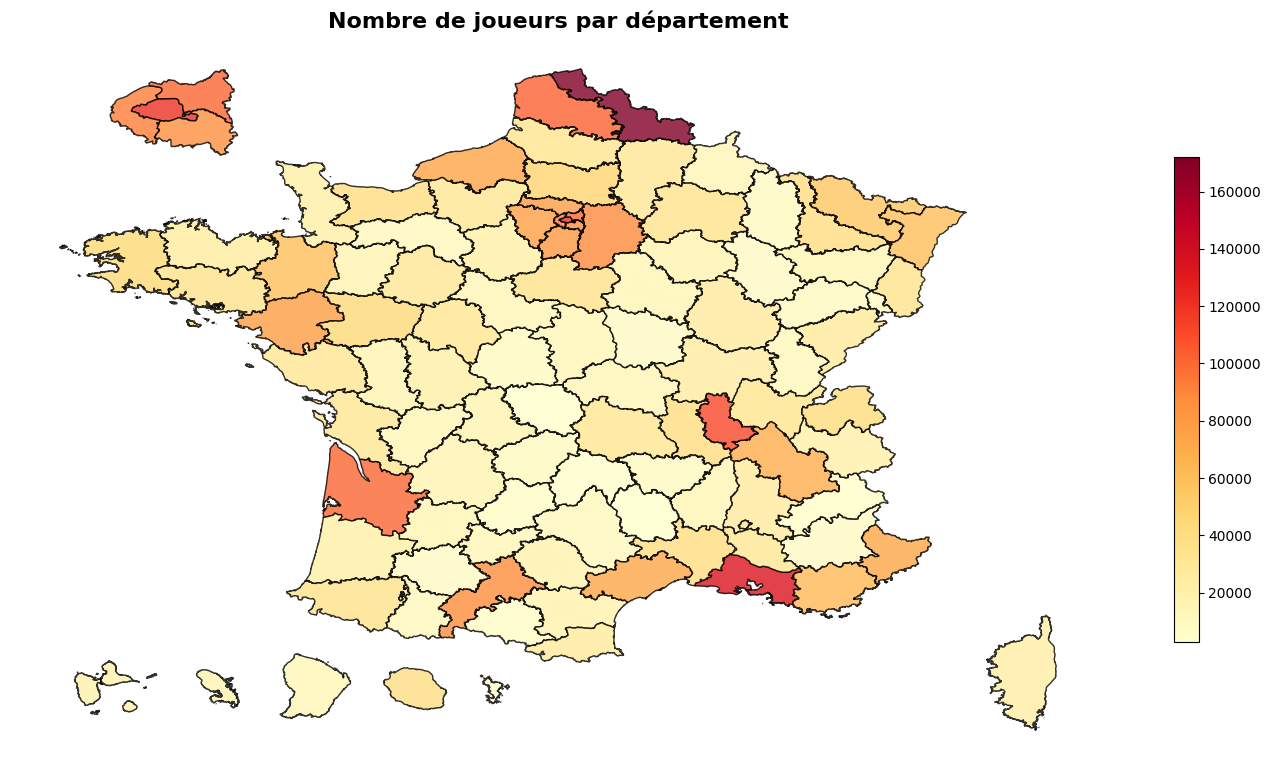

In [84]:
# Créer la carte avec la colonne "Nombre de joueurs de paris sportifs"
fig, ax = plt.subplots(figsize=(14, 10))

# Enlever les NaN pour la visualisation et garder le GeoDataFrame
joueurs_geo_map = joueurs_geo[joueurs_geo['Nombre de Joueurs Uniques tous segments'].notna()].copy()
joueurs_geo_map = gpd.GeoDataFrame(joueurs_geo_map, geometry='geometry')

# Créer la choroplèthe
joueurs_geo_map.plot(
    column='Nombre de Joueurs Uniques tous segments',
    ax=ax,
    legend=True,
    legend_kwds={'shrink': 0.5},
    cmap='YlOrRd',
    edgecolor='k',
    alpha=0.8
)

ax.set_title('Nombre de joueurs par département', fontsize=16, fontweight='bold')
ax.set_axis_off()
plt.tight_layout()
plt.show()

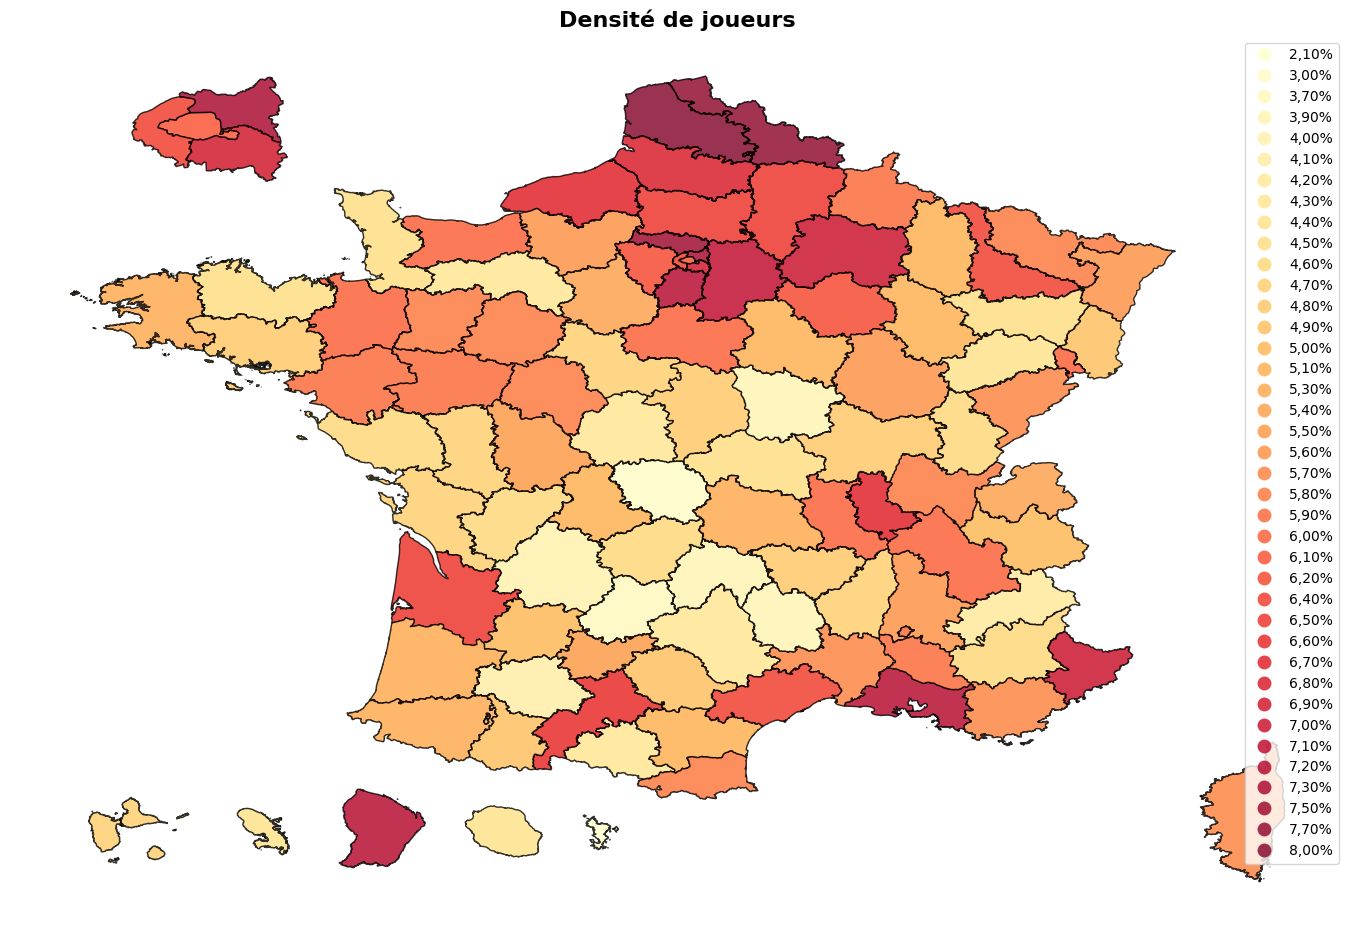

In [85]:
# Créer la carte avec la colonne "Nombre de joueurs de paris sportifs"
fig, ax = plt.subplots(figsize=(14, 10))

# Enlever les NaN pour la visualisation et garder le GeoDataFrame
joueurs_geo_map = joueurs_geo[joueurs_geo['Densité Paris Sportifs'].notna()].copy()
joueurs_geo_map = gpd.GeoDataFrame(joueurs_geo_map, geometry='geometry')

# Créer la choroplèthe
joueurs_geo_map.plot(
    column='Densité Paris Sportifs',
    ax=ax,
    legend=True,
    cmap='YlOrRd',
    edgecolor='k',
    alpha=0.8
)

ax.set_title('Densité de joueurs', fontsize=16, fontweight='bold')
ax.set_axis_off()
plt.tight_layout()
plt.show()

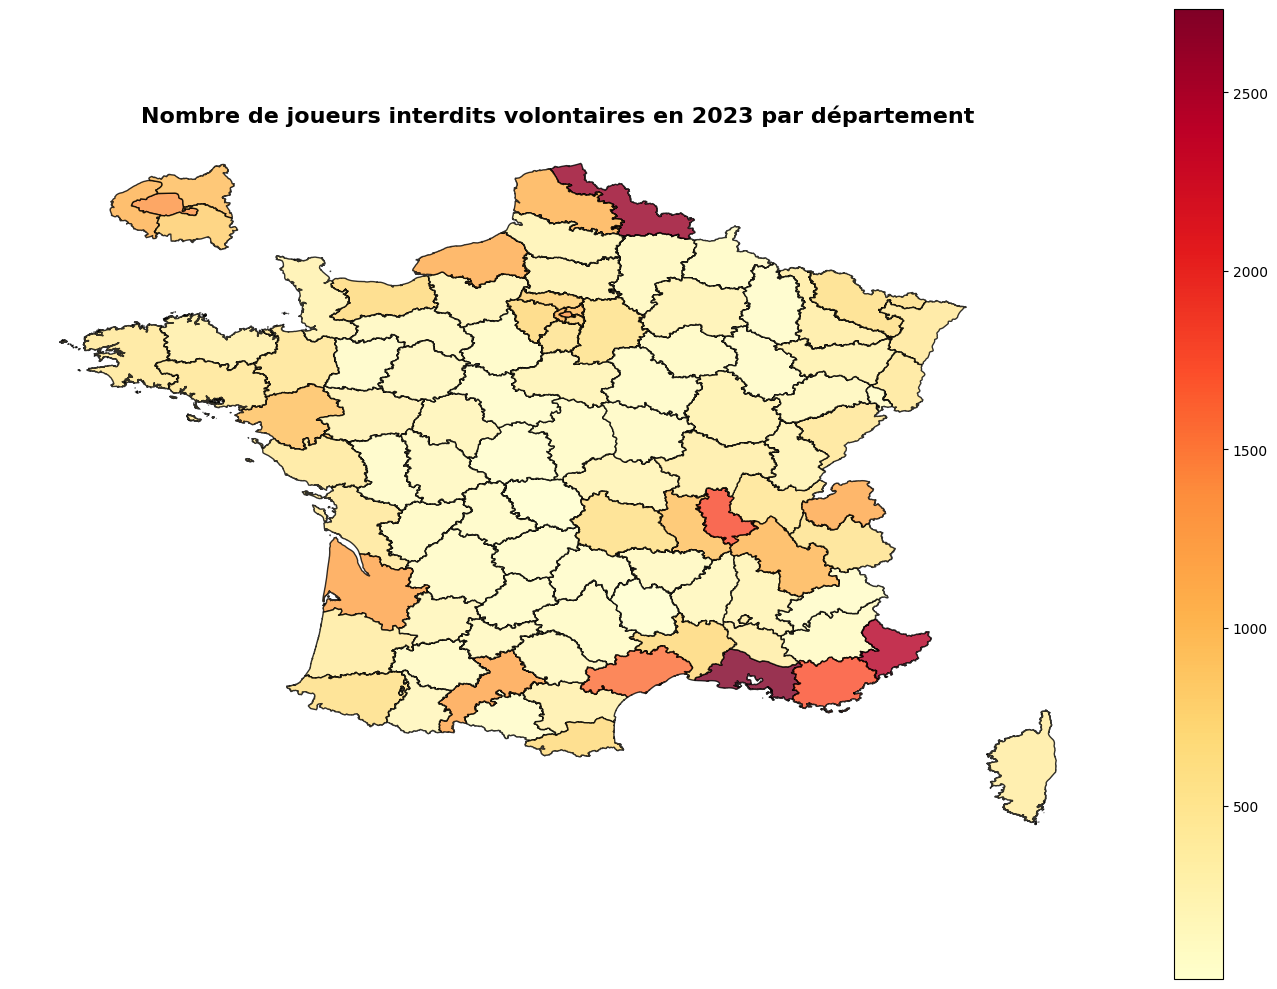

In [86]:
# Créer la carte avec la colonne "Nombre de joueurs de paris sportifs"
fig, ax = plt.subplots(figsize=(14, 10))

# Enlever les NaN pour la visualisation et garder le GeoDataFrame
joueurs_geo_map = joueurs_geo[joueurs_geo['nb_interdit_vol_2023'].notna()].copy()
joueurs_geo_map = gpd.GeoDataFrame(joueurs_geo_map, geometry='geometry')

# Créer la choroplèthe
joueurs_geo_map.plot(
    column='nb_interdit_vol_2023',
    ax=ax,
    legend=True,
    cmap='YlOrRd',
    edgecolor='k',
    alpha=0.8
)

ax.set_title('Nombre de joueurs interdits volontaires en 2023 par département', fontsize=16, fontweight='bold')
ax.set_axis_off()
plt.tight_layout()
plt.show()

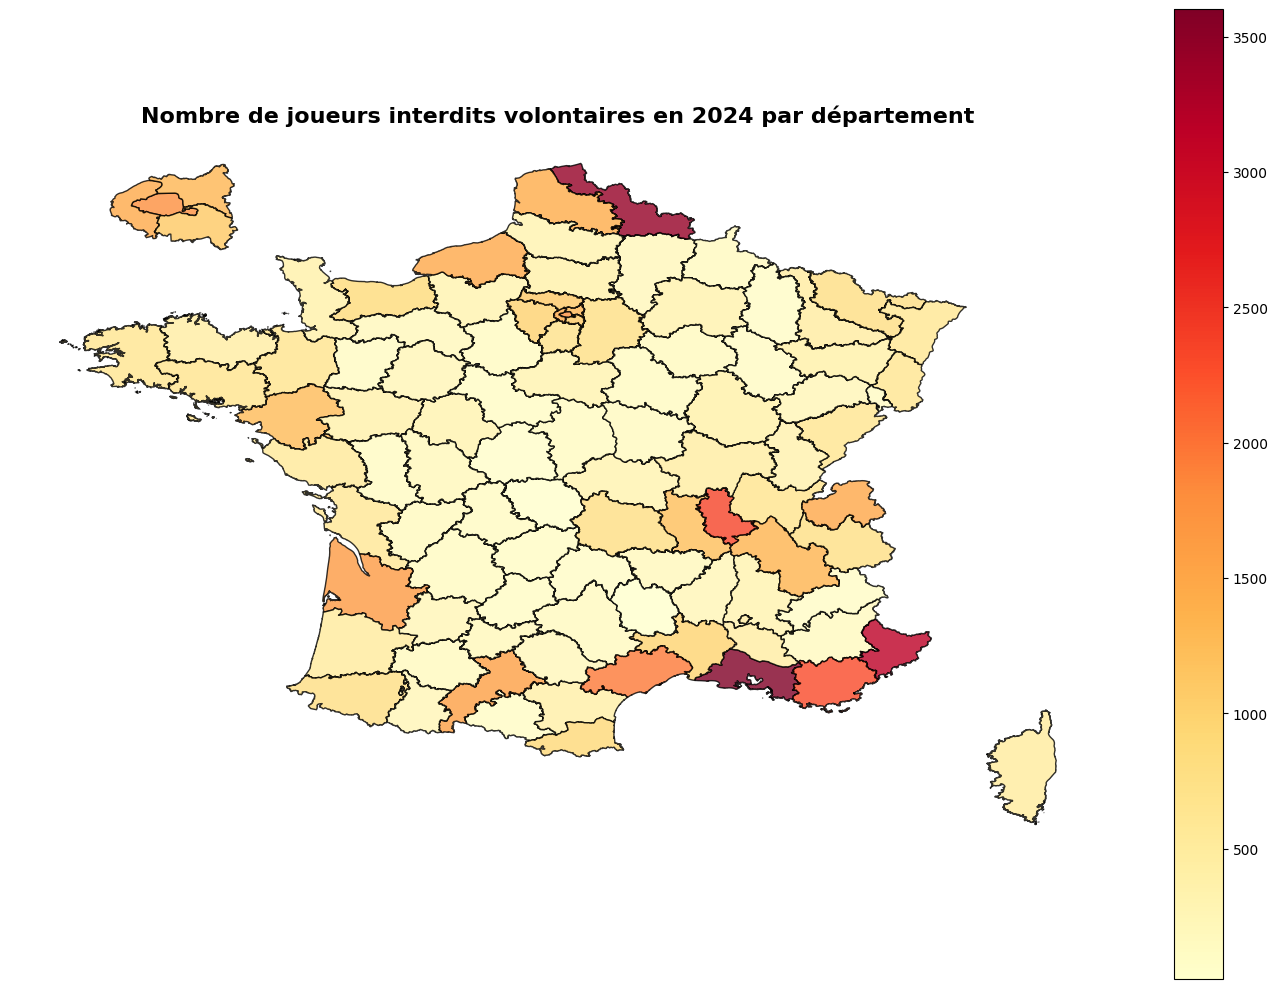

In [87]:
# Créer la carte avec la colonne "Nombre de joueurs de paris sportifs"
fig, ax = plt.subplots(figsize=(14, 10))

# Enlever les NaN pour la visualisation et garder le GeoDataFrame
joueurs_geo_map = joueurs_geo[joueurs_geo['nb_interdit_vol_2024'].notna()].copy()
joueurs_geo_map = gpd.GeoDataFrame(joueurs_geo_map, geometry='geometry')

# Créer la choroplèthe
joueurs_geo_map.plot(
    column='nb_interdit_vol_2024',
    ax=ax,
    legend=True,
    cmap='YlOrRd',
    edgecolor='k',
    alpha=0.8
)

ax.set_title('Nombre de joueurs interdits volontaires en 2024 par département', fontsize=16, fontweight='bold')
ax.set_axis_off()
plt.tight_layout()
plt.show()

In [88]:
joueurs_geo['augm_interdit'] = joueurs_geo['nb_interdit_vol_2024'] / joueurs_geo['nb_interdit_vol_2023'] * 100

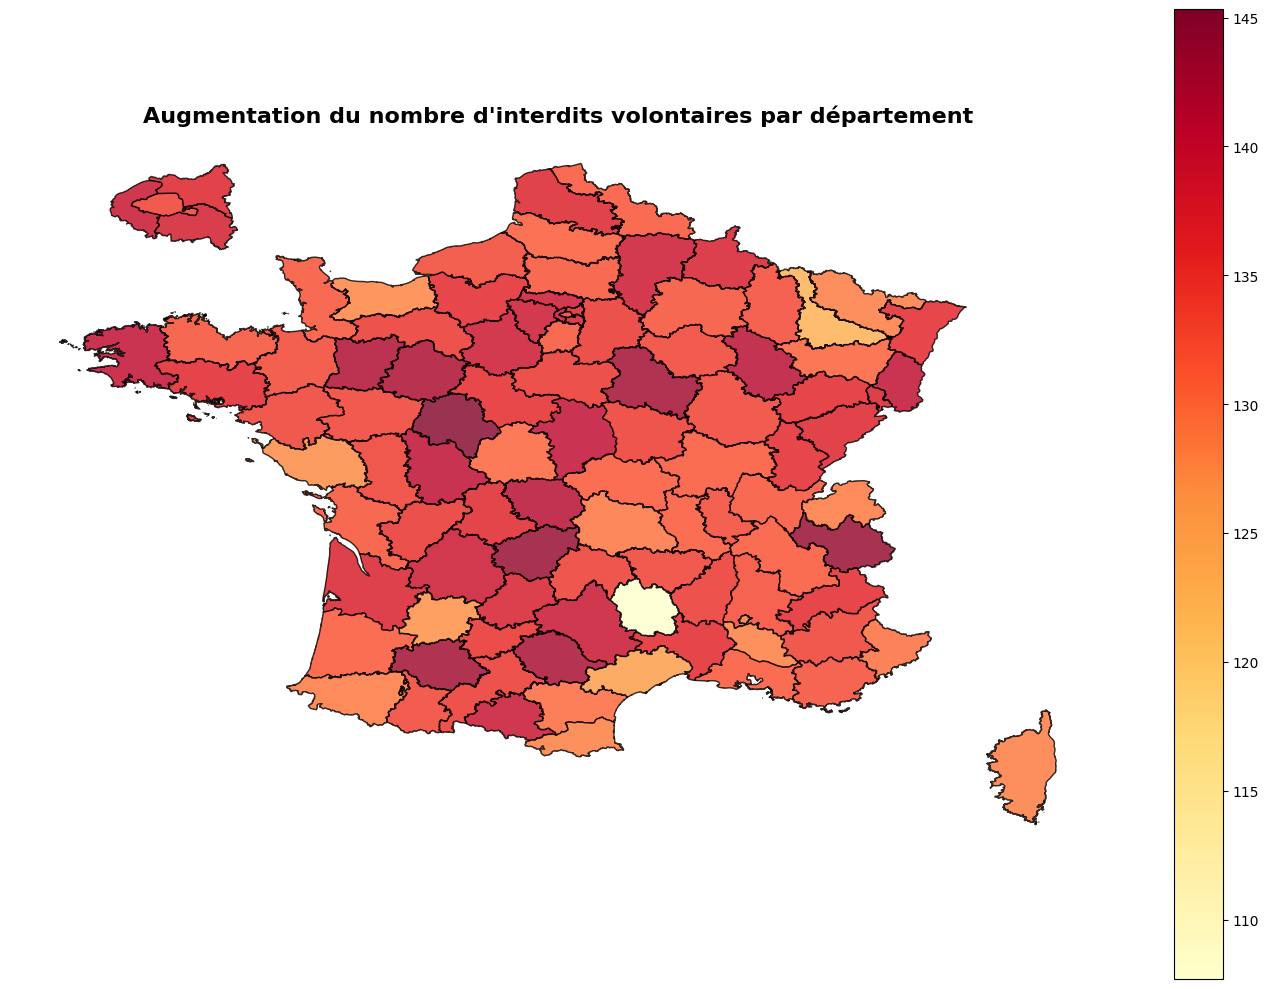

In [89]:
# Créer la carte avec la colonne "Nombre de joueurs de paris sportifs"
fig, ax = plt.subplots(figsize=(14, 10))

# Enlever les NaN pour la visualisation et garder le GeoDataFrame
joueurs_geo_map = joueurs_geo[joueurs_geo['augm_interdit'].notna()].copy()
joueurs_geo_map = gpd.GeoDataFrame(joueurs_geo_map, geometry='geometry')

# Créer la choroplèthe
joueurs_geo_map.plot(
    column='augm_interdit',
    ax=ax,
    legend=True,
    cmap='YlOrRd',
    edgecolor='k',
    alpha=0.8
)

ax.set_title("Augmentation du nombre d'interdits volontaires par département", fontsize=16, fontweight='bold')
ax.set_axis_off()
plt.tight_layout()
plt.show()

# DONNEES MARCHES

In [90]:
marches.head()

,Catégorie/Année,Au 31/12/2010,Au 31/12/2011,Au 31/12/2012,Au 31/12/2013,Au 31/12/2014,Au 31/12/2015,Au 31/12/2016,Au 31/12/2017,Au 31/12/2018,Au 31/12/2019,Au 31/12/2020,Au 31/12/2021,31/12/2022,31/12/2023,31/12/2024
0,Nombre dopérateurs,35,32,30,21,16,16,14,15,14,13,14,15,17,16,17
1,Nombre dagréments,48,48,33,30,31,29,27,28,27,26,27,28,30,28,29
2,Nombre agréments paris sportifs,15,16,9,9,11,11,12,13,13,13,14,15,17,16,17
3,Nombre agréments paris hippiques,8,9,8,8,8,8,8,8,8,7,7,7,6,5,5
4,Nombre agréments poker,25,23,16,13,12,10,7,7,6,6,6,6,7,7,7


In [91]:
marches['Catégorie/Année'].unique()

array(['Nombre d\x92opérateurs', 'Nombre d\x92agréments',
       'Nombre agréments paris sportifs',
       'Nombre agréments paris hippiques', 'Nombre agréments poker',
       'Nombre de comptes joueurs actifs total (en milliers)',
       'Nombre CJA Paris sportifs (en milliers)',
       'Nombre CJA Paris hippiques (en milliers)',
       'Nombre CJA Poker (en milliers)', 'Nombre de joueurs uniques',
       'Mises paris sportifs (en M\x80)', 'PBJ paris sportifs (en M\x80)',
       'Mises paris hippiques (en M\x80)',
       'PBJ paris hippiques (en M\x80)', 'PBJ poker (en M\x80)',
       'Budget marketing médias (en M\x80)', 'Part hommes PS',
       'Part femmes PS', 'Part hommes PH', 'Part femmes PH',
       'Part hommes PO', 'Part femmes PO', 'Part mises football',
       'Part mises tennis', 'Part mises basketball', 'Part mises rugby',
       nan, 'Données non disponibles'], dtype=object)

In [92]:
marches = marches.iloc[:26]

In [93]:
# Trouver toutes les lignes qui contiennent 'Part' dans le nom
part_rows = marches[marches['Catégorie/Année'].str.contains('Part', na=False, case=False)]['Catégorie/Année'].tolist()

# Convertir toutes ces lignes en numérique et en proportions (extraire le % d'abord, puis diviser par 100)
for part_category in part_rows:
    idx = marches[marches['Catégorie/Année'] == part_category].index[0]
    # Extraire les valeurs, enlever le %, convertir en float, puis en proportion
    marches.loc[idx, marches.columns[1:]] = pd.to_numeric(
        marches.loc[idx, marches.columns[1:]].astype(str).str.rstrip('%'), 
        errors='coerce'
    ) / 100

# Créer explicitement 'Part mises autres sports' (proportion qui complète à 1)
if 'Part mises autres sports' not in part_rows:
    autres_sports_row = marches[marches['Catégorie/Année'] == 'Part mises football'].copy()
    autres_sports_row['Catégorie/Année'] = 'Part mises autres sports'
    
    # Calculer la proportion pour les autres sports pour chaque année
    for col in marches.columns[1:]:
        total = 0
        sports_list = ['football', 'tennis', 'basketball', 'rugby']
        for sport in sports_list:
            idx = marches[marches['Catégorie/Année'] == f'Part mises {sport}'].index[0]
            total += marches.loc[idx, col]
        autres_sports_row[col] = 1 - total
    
    marches = pd.concat([marches, autres_sports_row], ignore_index=True)
    part_rows.append('Part mises autres sports')

# Créer les montants pour chaque catégorie de 'Part'
mises_idx = marches[marches['Catégorie/Année'] == 'Mises paris sportifs (en M\x80)'].index[0]
mises_total_num = pd.to_numeric(marches.loc[mises_idx, marches.columns[1:]], errors='coerce')

for part_category in part_rows:
    # Extraire le nom de la catégorie depuis 'Part mises [nom]'
    category_name = part_category.replace('Part mises ', '')
    
    # Vérifier si le montant existe déjà
    mises_category = f'Mises paris sportifs {category_name} (en M€)'
    if mises_category not in marches['Catégorie/Année'].values:
        row_part = marches[marches['Catégorie/Année'] == part_category].copy()
        new_row = row_part.copy()
        new_row['Catégorie/Année'] = mises_category
        
        # Calculer le montant = proportion * montant total
        for idx_col, col in enumerate(marches.columns[1:]):
            proportion = pd.to_numeric(row_part[col].values[0], errors='coerce')
            new_row[col] = proportion * mises_total_num.iloc[idx_col]
        
        marches = pd.concat([marches, new_row], ignore_index=True)

In [94]:
# Transposer le dataframe : années en lignes, catégories en colonnes
marches = marches.set_index('Catégorie/Année').T
marches.index.name = 'Année'
marches = marches.reset_index()

# Convertir les colonnes en numérique
for col in marches.columns[1:]:
    marches[col] = pd.to_numeric(marches[col], errors='coerce')

# Filtrer pour exclure 2010 et 2011
marches_filtered = marches[marches['Année'] >= '2012'].copy()
annees = marches_filtered['Année'].tolist()

marches.head()

Catégorie/Année,Année,Nombre dopérateurs,Nombre dagréments,Nombre agréments paris sportifs,Nombre agréments paris hippiques,Nombre agréments poker,Nombre de comptes joueurs actifs total (en milliers),Nombre CJA Paris sportifs (en milliers),Nombre CJA Paris hippiques (en milliers),Nombre CJA Poker (en milliers),...,Mises paris sportifs Part femmes PS (en M€),Mises paris sportifs Part hommes PH (en M€),Mises paris sportifs Part femmes PH (en M€),Mises paris sportifs Part hommes PO (en M€),Mises paris sportifs Part femmes PO (en M€),Mises paris sportifs football (en M€),Mises paris sportifs tennis (en M€),Mises paris sportifs basketball (en M€),Mises paris sportifs rugby (en M€),Mises paris sportifs autres sports (en M€)
0,Au 31/12/2010,35,48,15,8,25,2058,819,365,1188,...,35.84,362.88,85.12,407.68,40.32,NaN,NaN,NaN,NaN,NaN
1,Au 31/12/2011,32,48,16,9,23,2325,705,502,1686,...,47.36,473.60,118.40,526.88,65.12,NaN,NaN,NaN,NaN,NaN
2,Au 31/12/2012,30,33,9,8,16,2229,765,509,1713,...,56.40,571.05,133.95,620.40,84.60,415.95,133.95,56.40,21.15,77.55
3,Au 31/12/2013,21,30,9,8,13,2142,842,496,1240,...,67.84,686.88,161.12,746.24,101.76,517.28,161.12,76.32,25.44,67.84
4,Au 31/12/2014,16,31,11,8,12,2320,1142,488,1157,...,77.49,918.81,188.19,985.23,121.77,697.41,177.12,110.70,33.21,88.56


In [95]:
marches.columns

Index(['Année', 'Nombre dopérateurs', 'Nombre dagréments',
       'Nombre agréments paris sportifs', 'Nombre agréments paris hippiques',
       'Nombre agréments poker',
       'Nombre de comptes joueurs actifs total (en milliers)',
       'Nombre CJA Paris sportifs (en milliers)',
       'Nombre CJA Paris hippiques (en milliers)',
       'Nombre CJA Poker (en milliers)', 'Nombre de joueurs uniques',
       'Mises paris sportifs (en M)', 'PBJ paris sportifs (en M)',
       'Mises paris hippiques (en M)', 'PBJ paris hippiques (en M)',
       'PBJ poker (en M)', 'Budget marketing médias (en M)',
       'Part hommes PS', 'Part femmes PS', 'Part hommes PH', 'Part femmes PH',
       'Part hommes PO', 'Part femmes PO', 'Part mises football',
       'Part mises tennis', 'Part mises basketball', 'Part mises rugby',
       'Part mises autres sports',
       'Mises paris sportifs Part hommes PS (en M€)',
       'Mises paris sportifs Part femmes PS (en M€)',
       'Mises paris sportifs P

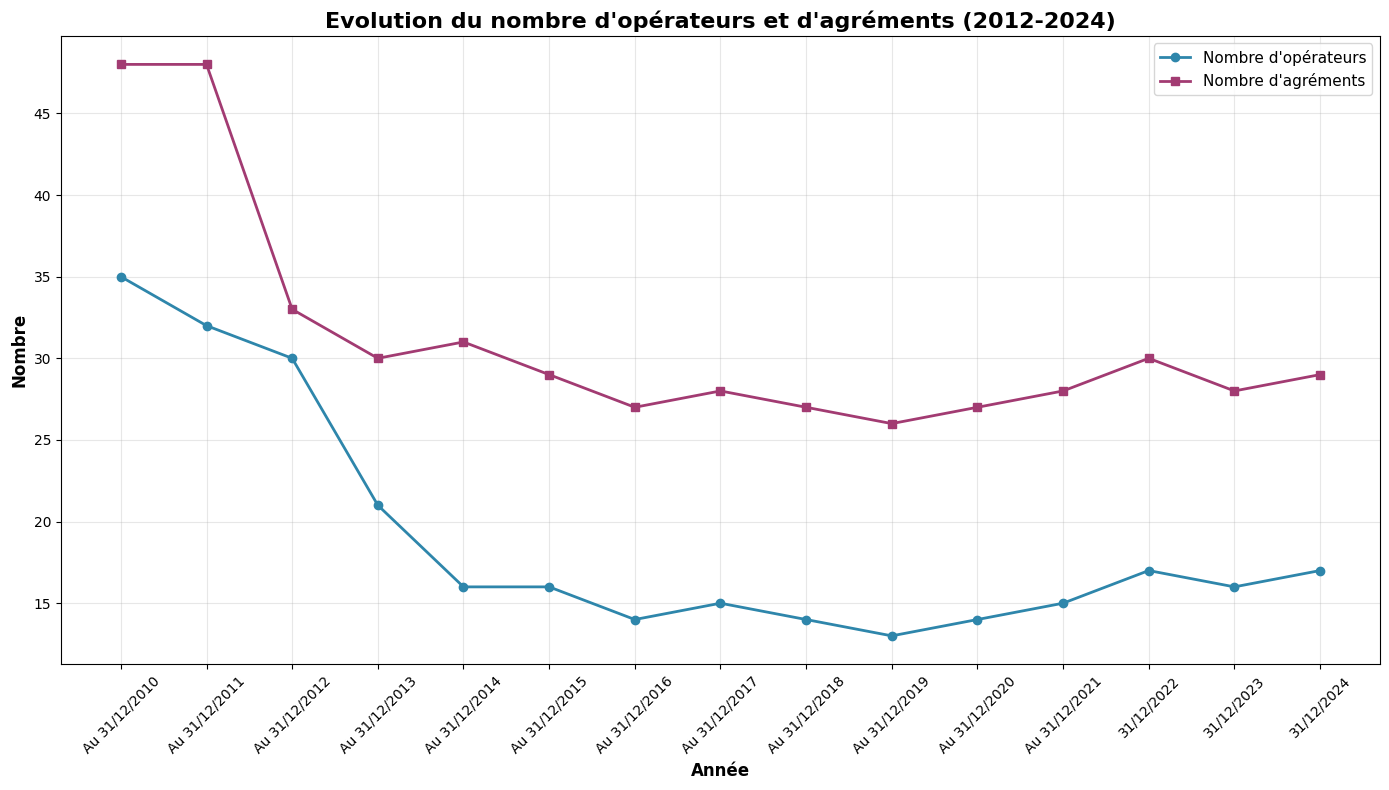

In [96]:
# Préparer les données pour le graphique
nb_operateurs = marches_filtered['Nombre dopérateurs'].astype(int).values
nb_agrements = marches_filtered['Nombre dagréments'].astype(int).values

# Créer le graphique
fig, ax = plt.subplots(figsize=(14, 8))

ax.plot(annees, nb_operateurs, marker='o', linewidth=2, label="Nombre d'opérateurs", color='#2E86AB')
ax.plot(annees, nb_agrements, marker='s', linewidth=2, label="Nombre d'agréments", color='#A23B72')

ax.set_xlabel('Année', fontsize=12, fontweight='bold')
ax.set_ylabel('Nombre', fontsize=12, fontweight='bold')
ax.set_title("Evolution du nombre d'opérateurs et d'agréments (2012-2024)", fontsize=16, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

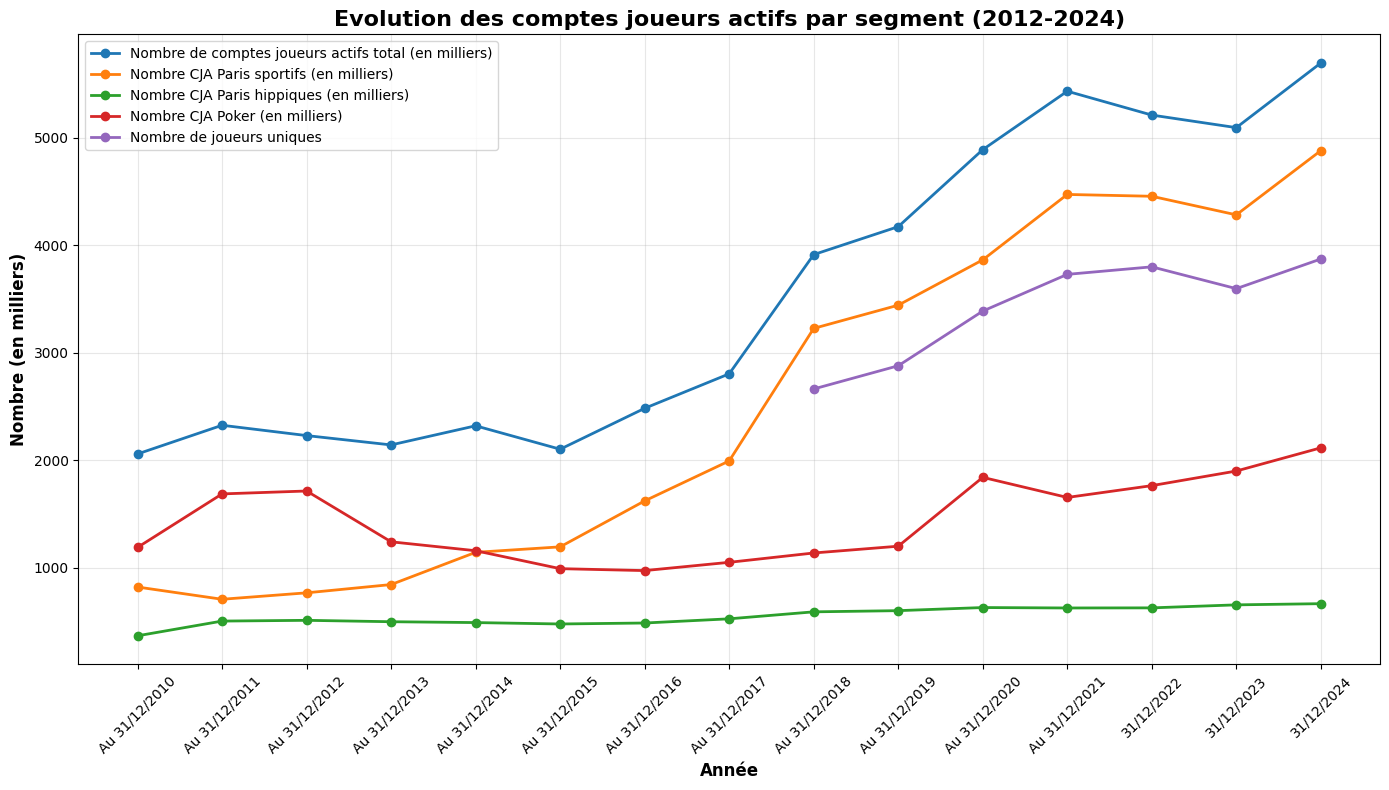

In [97]:
# Comptes joueurs actifs
categories_cja = [
    'Nombre de comptes joueurs actifs total (en milliers)',
    'Nombre CJA Paris sportifs (en milliers)',
    'Nombre CJA Paris hippiques (en milliers)',
    'Nombre CJA Poker (en milliers)',
    'Nombre de joueurs uniques'
]

fig, ax = plt.subplots(figsize=(14, 8))

for categorie in categories_cja:
    if categorie in marches_filtered.columns:
        valeurs = marches_filtered[categorie].values
        ax.plot(annees, valeurs, marker='o', linewidth=2, label=categorie)

ax.set_xlabel('Année', fontsize=12, fontweight='bold')
ax.set_ylabel('Nombre (en milliers)', fontsize=12, fontweight='bold')
ax.set_title('Evolution des comptes joueurs actifs par segment (2012-2024)', fontsize=16, fontweight='bold')
ax.legend(fontsize=10, loc='best')
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

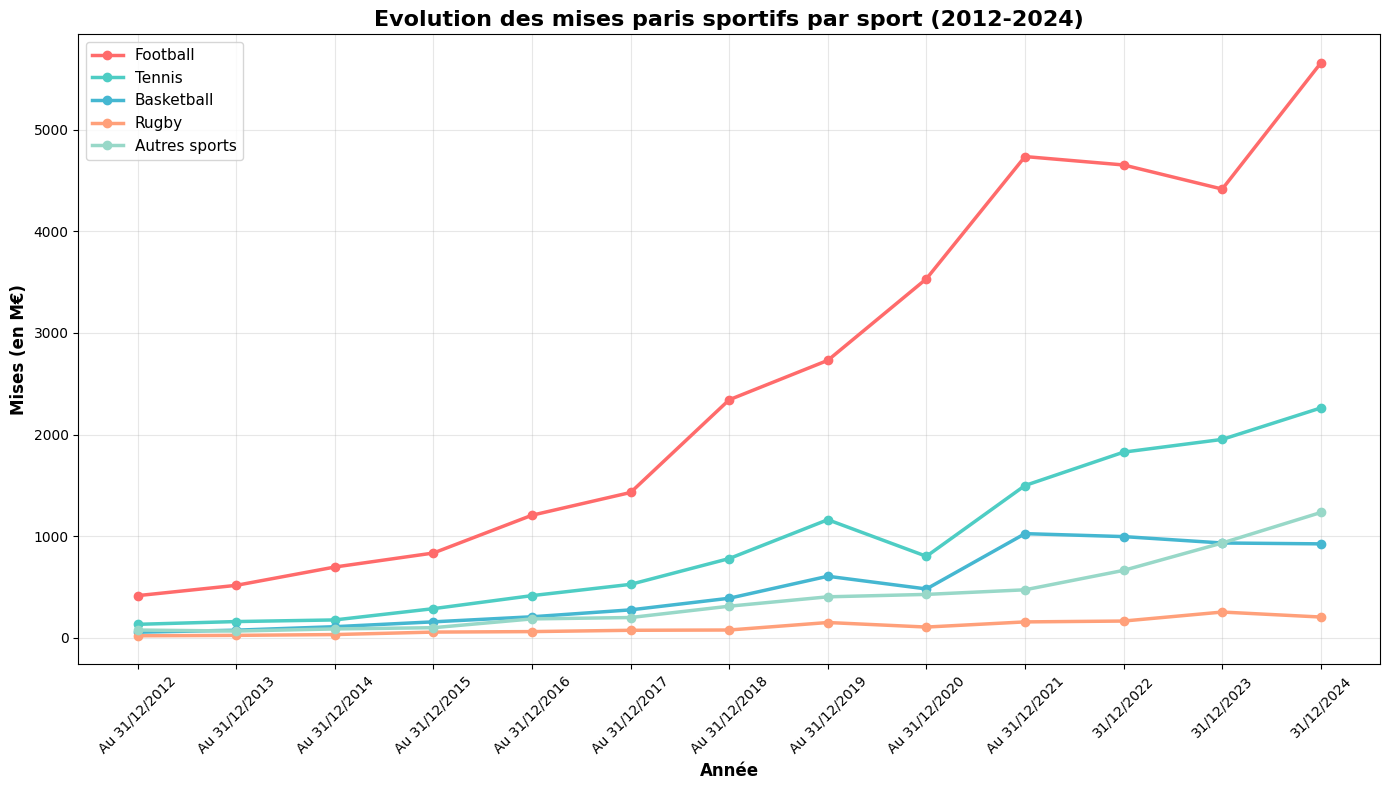

In [98]:
# Mises par sport
sports = ['football', 'tennis', 'basketball', 'rugby', 'autres sports']
couleurs_sports = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8']

fig, ax = plt.subplots(figsize=(14, 8))

# Ajouter la courbe du total
if 'Mises paris sportifs (en M€)' in marches_filtered.columns:
    valeurs_total = marches_filtered['Mises paris sportifs (en M€)'].values
    ax.plot(annees, valeurs_total, marker='d', linewidth=3, label='Total', color='#000000', zorder=10)

for idx, sport in enumerate(sports):
    categorie = f'Mises paris sportifs {sport} (en M€)'
    if categorie in marches_filtered.columns:
        valeurs = marches_filtered[categorie].values
        ax.plot(annees, valeurs, marker='o', linewidth=2.5, label=sport.capitalize(), color=couleurs_sports[idx])

ax.set_xlabel('Année', fontsize=12, fontweight='bold')
ax.set_ylabel('Mises (en M€)', fontsize=12, fontweight='bold')
ax.set_title('Evolution des mises paris sportifs par sport (2012-2024)', fontsize=16, fontweight='bold')
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

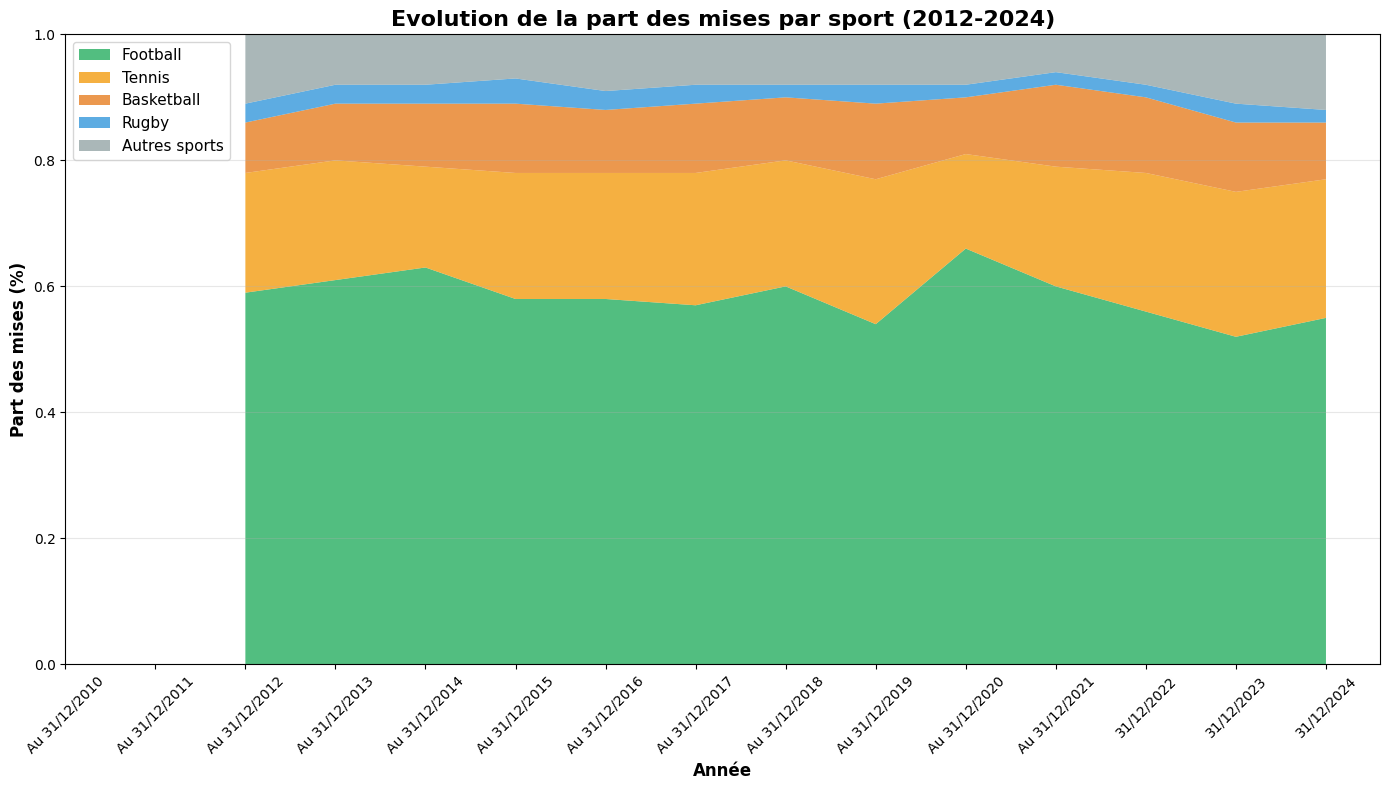

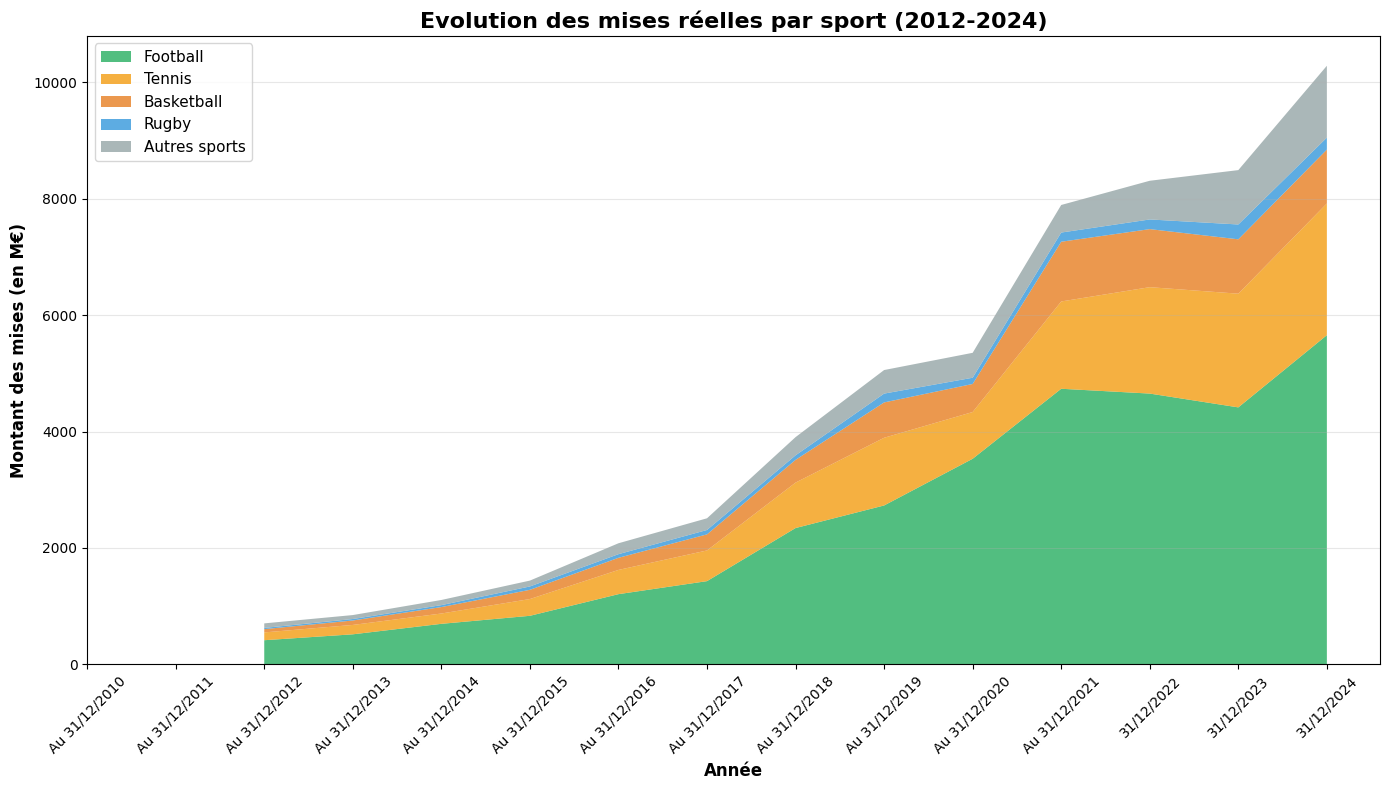

In [99]:
# Stacked area - Proportions et montants
sports = ['football', 'tennis', 'basketball', 'rugby', 'autres sports']
couleurs_sports = ['#27ae60', '#f39c12', '#e67e22', '#3498db', '#95a5a6']

# Graphique des proportions
fig, ax = plt.subplots(figsize=(14, 8))

data_proportions = [marches_filtered[f'Part mises {sport}'].values for sport in sports]
ax.stackplot(range(len(annees)), 
             data_proportions,
             labels=[sport.capitalize() for sport in sports],
             colors=couleurs_sports,
             alpha=0.8)

ax.set_xticks(range(len(annees)))
ax.set_xticklabels(annees, rotation=45)
ax.set_xlabel('Année', fontsize=12, fontweight='bold')
ax.set_ylabel('Part des mises (%)', fontsize=12, fontweight='bold')
ax.set_title('Evolution de la part des mises par sport (2012-2024)', fontsize=16, fontweight='bold')
ax.legend(fontsize=11, loc='upper left')
ax.set_ylim(0, 1)
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Graphique des montants
fig, ax = plt.subplots(figsize=(14, 8))

data_montants = [marches_filtered[f'Mises paris sportifs {sport} (en M€)'].values for sport in sports]
ax.stackplot(range(len(annees)), 
             data_montants,
             labels=[sport.capitalize() for sport in sports],
             colors=couleurs_sports,
             alpha=0.8)

ax.set_xticks(range(len(annees)))
ax.set_xticklabels(annees, rotation=45)
ax.set_xlabel('Année', fontsize=12, fontweight='bold')
ax.set_ylabel('Montant des mises (en M€)', fontsize=12, fontweight='bold')
ax.set_title('Evolution des mises réelles par sport (2012-2024)', fontsize=16, fontweight='bold')
ax.legend(fontsize=11, loc='upper left')
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

'Part hommes PS', 'Part femmes PS', 'Part hommes PH', 'Part femmes PH', 'Part hommes PO', 'Part femmes PO',
       'Mises paris sportifs Part hommes PS (en M€)',
       'Mises paris sportifs Part femmes PS (en M€)',
       'Mises paris sportifs Part hommes PH (en M€)',
       'Mises paris sportifs Part femmes PH (en M€)',
       'Mises paris sportifs Part hommes PO (en M€)',
       'Mises paris sportifs Part femmes PO (en M€)',

In [101]:
import itertools

Revoir ce graphique là, il me semblait que les mises ps était 3 fois plus grandes que ph. 

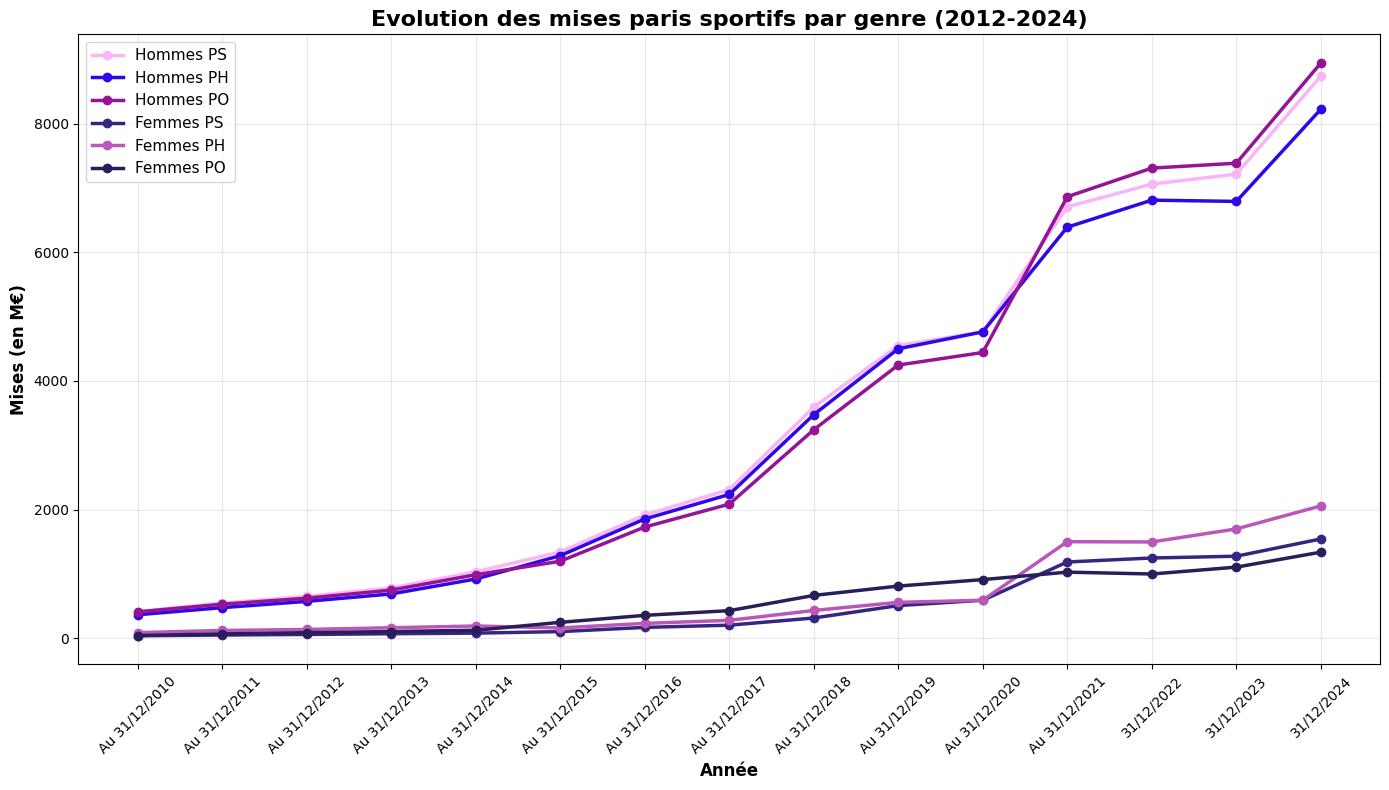

In [105]:
# Mises par sexe
sexe = ['hommes', 'femmes']
jeu = ['PS', 'PH', 'PO']
couleurs_sports = ["#F8B6F8", "#3007E6", "#951495", "#372681", "#B958B9", "#291E59"]

fig, ax = plt.subplots(figsize=(14, 8))

# Ajouter la courbe du total
if 'Mises paris sportifs (en M€)' in marches_filtered.columns:
    valeurs_total = marches_filtered['Mises paris sportifs (en M€)'].values
    ax.plot(annees, valeurs_total, marker='d', linewidth=3, label='Total', color='#000000', zorder=10)

for idx, (sexe_ind, jeu_ind) in enumerate(itertools.product(sexe, jeu)):
    categorie = f'Mises paris sportifs Part {sexe_ind} {jeu_ind} (en M€)'
    if categorie in marches_filtered.columns:
        valeurs = marches_filtered[categorie].values
        ax.plot(annees, valeurs, marker='o', linewidth=2.5, label=f"{sexe_ind.capitalize()} {jeu_ind}", color=couleurs_sports[idx])
        
ax.set_xlabel('Année', fontsize=12, fontweight='bold')
ax.set_ylabel('Mises (en M€)', fontsize=12, fontweight='bold')
ax.set_title('Evolution des mises paris sportifs par genre (2012-2024)', fontsize=16, fontweight='bold')
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()